In [ ]:
 import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory


In [ ]:
import tensorflow_datasets as tfds


In [ ]:

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteICQA2L/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteICQA2L/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 160
BATCH_SIZE = 32

size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_train = ds_train.batch(BATCH_SIZE)
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.batch(BATCH_SIZE)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = ds_train.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = ds_test.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [ ]:
IMG_SHAPE = size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 120)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy
(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(ds_train,
                    epochs=10,
                    validation_data=ds_test)

Epoch 1/10
375/375 [==============================] - 410s 1s/step - loss: 4.7617 - accuracy: 0.0803 - val_loss: 4.6988 - val_accuracy: 0.2695
Epoch 2/10
375/375 [==============================] - 408s 1s/step - loss: 4.6481 - accuracy: 0.2562 - val_loss: 4.5428 - val_accuracy: 0.4049
Epoch 3/10
375/375 [==============================] - 405s 1s/step - loss: 4.5436 - accuracy: 0.3658 - val_loss: 4.4215 - val_accuracy: 0.5420
Epoch 4/10
375/375 [==============================] - 406s 1s/step - loss: 4.4647 - accuracy: 0.4551 - val_loss: 4.3449 - val_accuracy: 0.6063
Epoch 5/10
375/375 [==============================] - 410s 1s/step - loss: 4.4182 - accuracy: 0.4914 - val_loss: 4.2993 - val_accuracy: 0.6366
Epoch 6/10
375/375 [==============================] - 414s 1s/step - loss: 4.3858 - accuracy: 0.5227 - val_loss: 4.2615 - val_accuracy: 0.6606
Epoch 7/10
375/375 [==============================] - 405s 1s/step - loss: 4.3617 - accuracy: 0.5400 - val_loss: 4.2390 - val_accuracy: 0.6707

In [ ]:
model.save('MV2_Stanford_Dogs.h5')

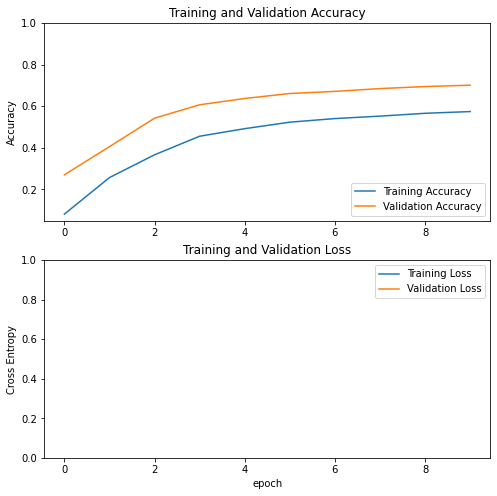

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy
(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(ds_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=ds_test)

Epoch 10/20
375/375 [==============================] - 592s 2s/step - loss: 4.2535 - accuracy: 0.5842 - val_loss: 4.1390 - val_accuracy: 0.6936
Epoch 11/20
375/375 [==============================] - 585s 2s/step - loss: 4.2329 - accuracy: 0.5938 - val_loss: 4.1374 - val_accuracy: 0.6951
Epoch 12/20
375/375 [==============================] - 609s 2s/step - loss: 4.2189 - accuracy: 0.6057 - val_loss: 4.1342 - val_accuracy: 0.6949
Epoch 13/20
375/375 [==============================] - 583s 2s/step - loss: 4.2106 - accuracy: 0.6173 - val_loss: 4.1259 - val_accuracy: 0.7030
Epoch 14/20
375/375 [==============================] - 586s 2s/step - loss: 4.2013 - accuracy: 0.6216 - val_loss: 4.1323 - val_accuracy: 0.6952
Epoch 15/20
375/375 [==============================] - 588s 2s/step - loss: 4.1963 - accuracy: 0.6288 - val_loss: 4.1286 - val_accuracy: 0.6980
Epoch 16/20
375/375 [==============================] - 591s 2s/step - loss: 4.1904 - accuracy: 0.6320 - val_loss: 4.1193 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

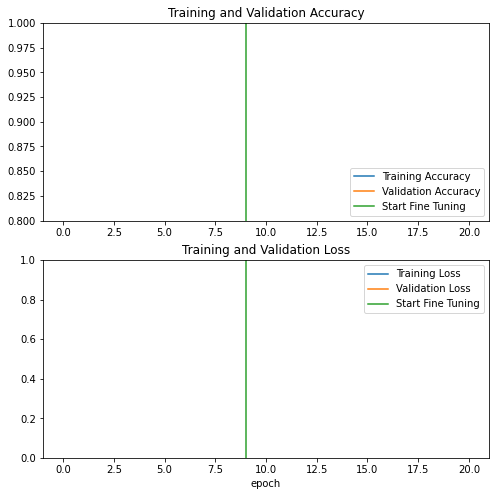

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('MV2_Sdogs.h5')

In [ ]:
IMG_SHAPE = size + (3,)
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 120)


In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(ds_train,
                    epochs=10,
                    validation_data=ds_test)

Epoch 1/10
375/375 [==============================] - 535s 1s/step - loss: 4.7789 - accuracy: 0.0922 - val_loss: 4.7587 - val_accuracy: 0.3383
Epoch 2/10
375/375 [==============================] - 538s 1s/step - loss: 4.7210 - accuracy: 0.3072 - val_loss: 4.6477 - val_accuracy: 0.4629
Epoch 3/10
375/375 [==============================] - 542s 1s/step - loss: 4.6204 - accuracy: 0.3879 - val_loss: 4.5280 - val_accuracy: 0.5267
Epoch 4/10
375/375 [==============================] - 544s 1s/step - loss: 4.5390 - accuracy: 0.4461 - val_loss: 4.4476 - val_accuracy: 0.5702
Epoch 5/10
375/375 [==============================] - 542s 1s/step - loss: 4.4857 - accuracy: 0.4838 - val_loss: 4.3910 - val_accuracy: 0.5983
Epoch 6/10
375/375 [==============================] - 546s 1s/step - loss: 4.4487 - accuracy: 0.5073 - val_loss: 4.3538 - val_accuracy: 0.6140
Epoch 7/10
375/375 [==============================] - 547s 1s/step - loss: 4.4204 - accuracy: 0.5264 - val_loss: 4.3242 - val_accuracy: 0.6331

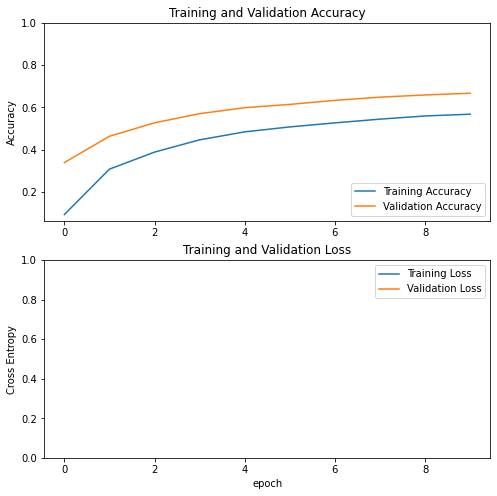

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('Eff_SDogs_inter.h5')

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  237


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy
(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(ds_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=ds_test)

Epoch 10/20
375/375 [==============================] - 839s 2s/step - loss: 4.2677 - accuracy: 0.6016 - val_loss: 4.1660 - val_accuracy: 0.6790
Epoch 11/20
375/375 [==============================] - 831s 2s/step - loss: 4.2211 - accuracy: 0.6158 - val_loss: 4.1484 - val_accuracy: 0.6850
Epoch 12/20
375/375 [==============================] - 830s 2s/step - loss: 4.2030 - accuracy: 0.6244 - val_loss: 4.1391 - val_accuracy: 0.6893
Epoch 13/20
375/375 [==============================] - 825s 2s/step - loss: 4.1863 - accuracy: 0.6397 - val_loss: 4.1330 - val_accuracy: 0.6923
Epoch 14/20
375/375 [==============================] - 828s 2s/step - loss: 4.1782 - accuracy: 0.6465 - val_loss: 4.1291 - val_accuracy: 0.6929
Epoch 15/20
375/375 [==============================] - 831s 2s/step - loss: 4.1692 - accuracy: 0.6548 - val_loss: 4.1259 - val_accuracy: 0.6938
Epoch 16/20
375/375 [==============================] - 831s 2s/step - loss: 4.1642 - accuracy: 0.6562 - val_loss: 4.1241 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

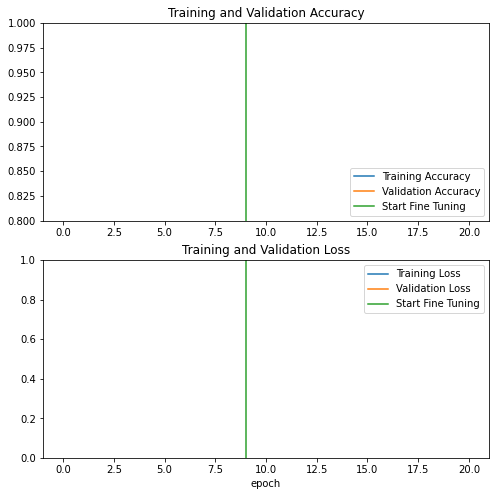

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('Effb0_Stanford_Dogs.h5')

# New section